In [ ]:
# Setup: paths work from notebooks/ (local) or repo root (Colab)
import sys
from pathlib import Path
ROOT = Path(".").resolve() if (Path(".") / "data").exists() else Path("..").resolve()
sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

# Data Ingest and Benchmark 

This notebook demonstrates GPU-accelerated telemetry loading with cuDF and Unified Virtual Memory (UVM), and benchmarks pandas vs cuDF. Inspired by [Speed Up Data Analytics on GPUs](https://developers.google.com/learn/pathways/speed-up-data-analytics-GPUs).

## Generate synthetic telemetry

In [7]:
from data.synthetic.generate_telemetry import generate_telemetry, _ensure_full_schema

df = generate_telemetry(n_rows=500_000, vehicle_count=5, duration_hours=24)
df = _ensure_full_schema(df)
out_dir = ROOT / "data" / "synthetic"
out_dir.mkdir(parents=True, exist_ok=True)
parquet_path = out_dir / "fleet_telemetry.parquet"
df.to_parquet(parquet_path, index=False)
print(f"Generated {len(df)} rows -> {parquet_path.resolve()}")

Generated 500000 rows -> ..\data\synthetic\fleet_telemetry.parquet


## Load with cuDF and UVM spill

In [8]:
from src.ingest.cudf_loader import load_telemetry

df = load_telemetry(str(parquet_path.resolve()), spill=True, use_cudf=None)
print(df.head())
print(f"Shape: {df.shape} (backend: {'cuDF' if 'cudf' in str(type(df)) else 'pandas'})")

   timestamp_ns vehicle_id sensor_type   accel_x   accel_y   accel_z  \
0             0       V000         imu -0.372758  0.333944  9.533071   
1             0       V003         imu -0.077508 -0.798546  9.930927   
2             0       V004         can       NaN       NaN       NaN   
3             0       V000      camera       NaN       NaN       NaN   
4             0       V003         can       NaN       NaN       NaN   

     gyro_x   gyro_y    gyro_z  orientation_w  ...  gear_position  latitude  \
0 -0.009397 -0.00211  0.000578       0.991726  ...            NaN       NaN   
1  0.003416 -0.00533 -0.014517       0.999316  ...            NaN       NaN   
2       NaN      NaN       NaN            NaN  ...            7.0       NaN   
3       NaN      NaN       NaN            NaN  ...            NaN       NaN   
4       NaN      NaN       NaN            NaN  ...            5.0       NaN   

   longitude  altitude_m  velocity_north  velocity_east  exposure_ms  \
0        NaN        

## Benchmark: pandas vs cuDF

In [9]:
from src.ingest.benchmark_loader import run_benchmark, benchmark_to_dataframe

results = run_benchmark(str(parquet_path.resolve()), operations=["load", "groupby", "filter", "sort"])
bm_df = benchmark_to_dataframe(results)
print(bm_df)

  backend operation    time_s  memory_mb
0  pandas      load  0.059831        0.0
1  pandas   groupby  0.013804        0.0
2  pandas    filter  0.005533        0.0
3  pandas      sort  0.006192        0.0


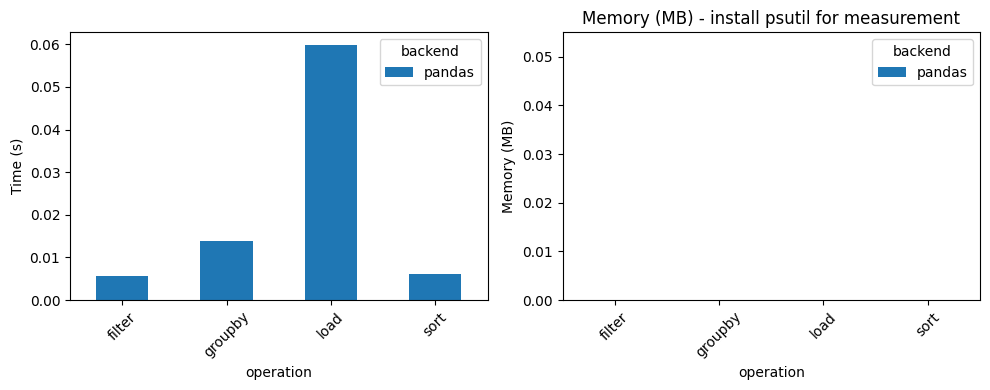

In [11]:
import matplotlib.pyplot as plt

pivot_time = bm_df.pivot(index="operation", columns="backend", values="time_s")
pivot_mem = bm_df.pivot(index="operation", columns="backend", values="memory_mb")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pivot_time.plot(kind="bar", ax=ax[0], rot=45, legend=True)
ax[0].set_ylabel("Time (s)")
ax[0].set_ylim(bottom=0)
ax[0].set_title("Benchmark: Time")
pivot_mem.plot(kind="bar", ax=ax[1], rot=45, legend=True)
ax[1].set_ylabel("Memory (MB)")
ax[1].set_ylim(bottom=0)
ax[1].set_title("Benchmark: Peak Memory")
plt.tight_layout()
plt.show()